# Notebook 2 - Mapa Geológico Preditivo

### Pré-processamento, modelagem dos dados & validação dos modelos

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: [Franco Naghetini](https://github.com/fnaghetini) & [Guilherme Silveira](https://github.com/guiasilveira)

<a id='1'></a>
##  Configurações iniciais

##### Importação de bibliotecas

In [1]:
from math import ceil                                        # arredondamento 'para cima'
import numpy as np                                           # operações numéricas de vetores
import pandas as pd                                          # manipulação de dataframes e series
import matplotlib.pyplot as plt                              # visualização de dados
import seaborn as sns                                        # visualização de dados

# pré-processamento dos dados
from sklearn.preprocessing import StandardScaler             # escalonamento dos dados
from sklearn.decomposition import PCA                        # análise de componentes principais
from sklearn.feature_selection import SelectKBest            # seleção univariada de features
from sklearn.feature_selection import f_classif              # seleção univariada de features (teste F ANOVA)
from sklearn.feature_selection import mutual_info_classif    # seleção univariada de features (informação mútua)
from sklearn.feature_selection import SelectFromModel        # seleção de features a partir de um modelo
from imblearn.over_sampling import SMOTE                     # superamostragem

# criação de classes scikit-learn e pipelines
from sklearn.base import BaseEstimator, TransformerMixin     # criação de classes personalizadas
from imblearn.pipeline import Pipeline                       # criação de pipelines

# modelagem dos dados
from sklearn.linear_model import LogisticRegression          # logistic regression
from sklearn.linear_model import RidgeClassifier             # ridge classifier
from sklearn.naive_bayes import GaussianNB                   # gaussian naive bayes
from sklearn.neighbors import KNeighborsClassifier           # k-nearest neighbor
from sklearn.svm import SVC                                  # support vector machines
from sklearn.ensemble import RandomForestClassifier          # random forest
from xgboost import XGBClassifier                            # xgboost

# validação dos modelos
from sklearn.model_selection import StratifiedKFold          # amostragem estratificada
from sklearn.model_selection import cross_val_score          # scores de validação cruzada
from sklearn.metrics import accuracy_score                   # acurácia
from sklearn.metrics import f1_score                         # f1-score
from sklearn.metrics import precision_score                  # precisão
from sklearn.metrics import recall_score                     # revocação
from sklearn.metrics import confusion_matrix                 # matriz de confusão
from sklearn.metrics import classification_report            # report de métricas de classificação

# tuning dos modelos
from sklearn.model_selection import RandomizedSearchCV       # random search
from sklearn.model_selection import GridSearchCV             # grid search

import warnings                                              # desabilitar avisos
warnings.filterwarnings("ignore")

%matplotlib inline

##### Importação do banco de dados

In [2]:
df_original = pd.read_csv("data/data_nb2.csv",sep=",")

In [3]:
# criação de uma cópia (deep) do dataframe original
df = df_original.copy(deep = True)

##### Visualização das primeiras linhas do banco de dados

In [4]:
df.head(10)

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B06,B07,B08,B09,R,G,B,TARGET,UNID,COD
0,638663.68,7981552.08,0.076001,0.38,3.98,2.21,3.56,3.11,6.51,0.49,...,15656,11371,7669,5089,208,199,185,6,Fm_GM,PP4egm
1,638663.68,7981489.58,0.054137,0.41,3.66,2.44,3.60,3.11,6.91,0.47,...,17906,13743,8706,5077,195,189,169,6,Fm_GM,PP4egm
2,638726.18,7981489.58,0.071591,0.57,5.30,2.63,4.23,2.72,6.97,0.41,...,17693,13716,8699,5083,197,160,153,6,Fm_GM,PP4egm
3,638788.68,7981489.58,0.055794,0.80,7.26,2.88,4.92,2.40,7.16,0.36,...,16064,11973,8334,5083,226,208,202,6,Fm_GM,PP4egm
4,638851.18,7981489.58,0.033372,1.05,9.20,3.17,5.54,2.21,7.50,0.33,...,15789,11648,8081,5085,161,167,130,6,Fm_GM,PP4egm
5,638788.68,7981427.08,0.028260,0.85,6.60,2.97,4.92,2.51,7.64,0.36,...,15269,11403,8028,5079,142,107,106,6,Fm_GM,PP4egm
6,638663.68,7981427.08,0.051313,0.44,3.20,2.62,3.62,3.14,7.37,0.44,...,18497,14848,9045,5091,226,175,200,6,Fm_GM,PP4egm
7,638726.18,7981427.08,0.047716,0.62,4.74,2.80,4.25,2.80,7.47,0.40,...,16202,12264,8508,5097,170,107,122,6,Fm_GM,PP4egm
8,638663.68,7981364.58,0.048052,0.49,2.99,2.77,3.63,3.18,7.87,0.42,...,17907,14332,8848,5082,224,150,198,6,Fm_GM,PP4egm
9,638726.18,7981364.58,0.044078,0.64,4.20,2.87,4.23,2.87,7.93,0.38,...,15765,11898,8060,5098,243,171,217,6,Fm_GM,PP4egm


<a id='2'></a>
## Variáveis Globais & funcões auxiliares

##### Variáveis globais

In [5]:
# coordenadas
COORD = ['X','Y']

# features
FEAT = df.columns[2:-3]

# features geofísicas
GF = FEAT[:8]

# canais radiométricos
RADIO = ['K','TH','U']

# sensores remotos
SR = FEAT[8:21]

# meta dados
META = ['UNID','COD']

# dicionário litoestratigráfico
dic_lith = {}
for k, v1, v2 in zip(df['TARGET'].unique(), df['UNID'].unique(), df['COD'].unique()):
    dic_lith[k] = [v1, v2]

##### Parâmetros dos gráficos

In [6]:
# fonte: Times New Roman, tamanho: 12
plt.rcParams.update({'font.family':'Times New Roman', 'font.size' : 12})

fs_title =  16         # tamanho da fonte dos títulos
cm       = 'Dark2'     # mapa de cores
mk       = 's'         # estilo do marcador (quadrado)
sz       =  2          # tamanho do marcador    
col      = 'lightgray' # cor dos histogramas
ec       = 'black'     # cor das bordas dos histogramas
pad      = 15.0        # offset dos títulos e labels

##### customTrainTestSplit(df :: dataframe, threshold :: int, coords :: bool)

Realiza a divisão dos dados entre treino e teste. O conjunto de treino é obtido a partir de uma amostragem aleatória de 100 exemplos por unidade litoestratigráfica. Caso uma unidade apresente um número de exemplos < `threshold`, 70% de suas instâncias são aleatoriamente amostradas.

Parâmetros:
- `df` : dataframe (n, m) com os dados brutos
- `threshold` : número de exemplos a serem amostrados por classe. Esses exemplos irão compor o conjunto de treino. Default = 100.
- `coords` : se `True`, retorna as coordenadas `X` e `Y` de treino e teste

Retorna:
- `X_train` : narray (t, m) com as features do conjunto de treino
- `y_train` : narray (t,  ) com o target do conjunto de treino
- `coord_train` : narray (t, 2) com as coordenadas do conjunto de treino (apenas se `coords = True`)
- `X_test` : narray (n-t, m) com as features do conjunto de teste
- `y_test` : narray (n-t,  ) com o target do conjunto de teste
- `coord_test` : narray (n-t, 2) com as coordenadas do conjunto de teste (apenas se `coords = True`)

In [7]:
def customTrainTestSplit(df, threshold = 100, coords = False):
    # semente aleatória
    np.random.seed(42)
    # embaralhando dataframe de entrada
    table = df.sample(frac = 1).reset_index(drop = True)
    # lista de unidades (classes)
    classes = table['TARGET'].unique()
    # dataframe vazio de treino
    train = pd.DataFrame()
    
    # Para cada unidade
    for c in classes:
        # dataframe filtrado para cada unidade específica
        unid = table[table['TARGET'] == c]
        # número de exemplos de uma unidade
        len_unid = len(unid)
        # se o número de ocorrência <= threshold
        if len_unid <= threshold:
            # amostragem aleatória de 70% dos exemplos da unidade
            𝒮 = unid.sample(ceil(len_unid * 0.7))
        # se o número de ocorrência > threshold
        else:
            # amostragem aleatória de 100 exemplos da unidade
            𝒮 = unid.sample(threshold)   
        # populando dataframe de treino
        train = pd.concat([train, 𝒮])
            
    # embaralhando os dados de treino  e teste
    test = table.drop(train.index).sample(frac = 1).reset_index(drop = True)
    train = train.sample(frac = 1).reset_index(drop = True)
    
    # divisão entre features e target nos dados de treino
    X_train, y_train, coord_train = train[FEAT].values, train['TARGET'].values, train[COORD].values
    # divisão entre features e target nos dados de teste
    X_test, y_test, coord_test = test[FEAT].values, test['TARGET'].values, test[COORD].values
    
    # retorna as features, target e coordenadas de treino e teste
    if coords:
        return X_train, y_train, coord_train, X_test, y_test, coord_test
    # retorna apenas as features e target de treino e teste
    else:
        return X_train, y_train, X_test, y_test

##### MaskedPCA(n_components :: int, mask :: narray)

Classe que realiza uma Análise de Componentes Principais (PCA) apenas das features definidas pelo parâmetro `mask`. O número de componentes principais pode ser informado por meio do parâmetro `n_components`.

Parâmetros:
- `n_components` : número (int) de componentes principais
- `mask` : narray (n, ), sendo `n` o número de features utilizadas na PCA. Este parâmetro indica os índices das colunas das features.

Retorna:
- instância da classe MaskedPCA.

In [8]:
class MaskedPCA(BaseEstimator, TransformerMixin):

    def __init__(self, n_components = 2, mask = None):
        self.n_components = n_components
        self.mask = mask

    def fit(self, X, y = None):
        self.pca = PCA(n_components = self.n_components)
        mask = self.mask
        mask = self.mask if self.mask is not None else slice(None)
        self.pca.fit(X[:, mask])
        return self

    def transform(self, X, y = None):
        mask = self.mask if self.mask is not None else slice(None)
        pca_transformed = self.pca.transform(X[:, mask])
        if self.mask is not None:
            remaining_cols = np.delete(X, mask, axis = 1)
            return np.hstack([remaining_cols, pca_transformed])
        else:
            return pca_transformed

##### univariateSelector(X_train :: narray, y_train :: narray, X_test :: narray,  func :: function, n_features :: int)

Seleciona as `n_features` mais importantes de acordo com uma função `func` passada pelo usuário.

Parâmetros:
- `X_train` : narray (t, m) das features de treino
- `y_train` : narray (t,  ) do target de treino
- `X_test` : narray (n-t, m) das features de teste
- `func` : função definida para selecionar as features. As duas opções são *f_classif* e *mutual_info_classif*
- `n_features` : número (int) de features a serem selecionadas. Default = 10

Retorna:
- `X_train_fs` : narray(t, n_features) das features de treino selecionadas
- `X_test_fs` : narray(n-t, n_features) das features de teste selecionadas
- `selector.scores_` : narray(n_features, ) com os scores calculados

In [9]:
def univariateSelector(X_train, y_train, X_test, func, n_features = 10):
    # instanciando seletor de features
    selector = SelectKBest(score_func = func, k = n_features)
    
    # treinando seletor de features
    selector.fit(X_train, y_train)
    
    # transformação das features de treino
    X_train_fs = selector.transform(X_train)
    # transformação das features de teste
    X_test_fs = selector.transform(X_test)
    
    return X_train_fs, X_test_fs, selector.scores_

##### dicScores(score :: narray, k :: int, feature_labels :: list)

Cria um dicionário com as `k` features mais importantes e seus respectivos scores `score`.

Parâmetros:
- `score` : narray (k,  ) com os scores das features mais importantes
- `k` : número (int) de features mais importantes. Default = 10
- `feature_labels` : lista com os nomes das features

Retorna:
- `dict` : dicionário com `k` features (chaves) e `k` scores (valores)

In [10]:
def dicScores(score, k = 10, feature_labels = None):
    # dicionário vazio
    fs_dic = {}
    
    # populando o dicionário com os scores
    for f, s in zip(feature_labels, list(score)):
        fs_dic[f] = round(s, 2)
    
    # ordenando dicionário de forma descendente
    list_sorted = sorted(fs_dic.items(), key = lambda x: x[1], reverse = True)
    # fatiando lista de acordo com o 'k' informado
    sliced_list = list_sorted[:k][:k]
    
    # retorna dicionário
    return dict(sliced_list)

##### plotSelectionScores(score :: narray, k :: int, feature_labels :: list)

Plota um gráfico de barras com as `k` features mais importantes.

Parâmetros:
- `score` : narray (n_features, ) com os scores de importância das features
- `labels` : lista com os nomes das features
- `k` : número (int) de features mais importantes. Default = 10

Retorna:
- Gráfico de barras com as `k` features mais importantes

In [11]:
def plotSelectionScores(score, labels, k = 10):
    # dicionário de features e seus scores
    dic = dicScores(score, k = k, feature_labels = labels)
    # features
    features = list(dic.keys())
    # scores
    values = list(dic.values())
    
    # dimensões do gráfico
    plt.figure(figsize = (k*0.6,3))
    # gráfico de barras f-score x features
    plt.bar(x = features, height = values, color = col, edgecolor = ec)
    # título e labels
    plt.title(f"{k} features mais importantes", size = fs_title)
    plt.ylabel('Score', size = 14)
    plt.yticks(size = 12)
    plt.xticks(rotation = 45, size = 12)

    plt.tight_layout();

##### modelSelector(X_train :: narray, y_train :: narray, X_test :: narray,  model :: object, n_features :: int)

Seleciona as `n_features` mais importantes de acordo com um modelo.

Parâmetros:
- `X_train` : narray (t, m) das features de treino
- `y_train` : narray (t,  ) do target de treino
- `X_test` : narray (n-t, m) das features de teste
- `model` : modelo utilizado para a seleção de features. São opções: *LogisticRegression* e *RandomForestClassifier*, por exemplo
- `n_features` : número (int) de features a serem selecionadas. Default = 10

Retorna:
- `X_train_fs` : narray(t, n_features) das features de treino selecionadas
- `X_test_fs` : narray(n-t, n_features) das features de teste selecionadas
- `selector` : objeto que representa o seletor de features já treinado

In [12]:
def modelSelector(X_train, y_train, X_test, model, n_features = 10):
    # instanciando seletor de features
    selector = SelectFromModel(estimator = model, threshold = -np.inf, max_features = n_features)
    
    # treinando seletor
    selector.fit(X_train, y_train)
    
    # transformação das features de treino
    X_train_fs = selector.transform(X_train)
    # transformação das features de teste
    X_test_fs = selector.transform(X_test)
    
    return X_train_fs, X_test_fs, selector

##### validationReport(pipeline :: pipeline, X_train :: narray, y_train :: narray, cv :: object)

Retorna um report com as métricas resultantes da validação cruzada por modelo. As métricas incluem F1-score, precisão, revocação (weighted e macro) e acurácia.

Parâmetros:
- `pipeline` : pipeline completa com as etapas de processamento até a instanciação do classificador
- `X_train` : narray (t, m) das features de treino
- `y_train` : narray (t, ) do target de treino
- `cv` : objeto de validação cruzada

Retorna:
- `df_metrics` : dataframe com as métricas resultantes da validação cruzada por modelo

In [13]:
def validationReport(pipeline, X_train, y_train, cv):
    # colunas do dataframe
    cols = pipeline.keys()
    # índices do dataframe
    index = [f'{m}_{avg}' for avg in ['weighted','macro'] for m in ['f1','precision','recall']]
    index.append('accuracy')
    # criação do dataframe
    df_metrics = pd.DataFrame(columns = cols, index = index)

    # para cada modelo
    for pipe in pipeline.keys():
        # lista de métricas vazia
        metrics = []
        # para cada tipo de média das métricas
        for i in index:
            # validação cruzada
            m = cross_val_score(pipeline[pipe], X_train, y_train, scoring = i, cv = cv)
            # média dos scores dos folds
            μₘ = round(m.mean(), 3)
            # populando lista com o score obtido
            metrics.append(μₘ)
    
        # criação de uma coluna com as métricas de um modelo
        df_metrics[pipe] = metrics
    
    return df_metrics

##### testReport(dic_ŷ :: dict, y_test :: narray)

Retorna um report com as métricas resultantes do conjunto de teste por modelo. As métricas incluem F1-score, precisão, revocação (weighted e macro) e acurácia.

Parâmetros:
- `dic_ŷ` : dicionário com as predições de cada modelo
- `y_test` : narray (n-t, ) com o target do conjunto de teste

Retorna:
- `df_metrics` : dataframe com as métricas resultantes do conjunto de teste por modelo

In [14]:
def testReport(dic_ŷ, y_test):
    # colunas do dataframe
    cols = dic_ŷ.keys()
    # índices do dataframe
    index = [f'{m}_{avg}'for avg in ['weighted','macro'] for m in ['f1','precision','recall']]
    index.append('accuracy')
    # criação do dataframe
    df_metrics = pd.DataFrame(columns = cols, index = index)

    # para cada predição de modelo
    for ŷ in dic_ŷ:
        # lista de métricas vazia
        metrics = []
        # para cada tipo de média das métricas
        for avg in ['weighted', 'macro']:
            # f1-score
            f1 = round(f1_score(y_test, dic_ŷ[ŷ], average = avg), 3)
            metrics.append(f1)
            # precisão
            p = round(precision_score(y_test, dic_ŷ[ŷ], average = avg), 3)
            metrics.append(p)
            # revocação
            r = round(recall_score(y_test, dic_ŷ[ŷ], average = avg), 3)
            metrics.append(r)
        # acurácia
        acc = round(accuracy_score(y_test, dic_ŷ[ŷ]), 3)
        metrics.append(acc)

        # criação de uma coluna com as métricas de um modelo
        df_metrics[ŷ] = metrics

    return df_metrics

##### plotPrediction(ŷ :: narray, model :: string)

Plota o mapa geológico preditivo para um dado modelo `model`, o mapa geológico e o mapa com os exemplos de treino.

Parâmetros:
- `ŷ` : narray (n-t, ) com as predições do target de um determinado modelo
- `model` : string com o nome do modelo utilizado. Corresponde ao título do mapa geológico preditivo

Retorna:
- Mapa geológico preditivo do modelo `model`, mapa geológico de campo e o mapa com os exemplos de treino

In [15]:
def plotPrediction(ŷ, model = None):
    # criação de um dataframe com as predições
    y_hat = pd.DataFrame(ŷ, columns = ['TARGET'])
    # dataframe das coordenadas do conjunto de teste
    coord_test = test[['X','Y']]
    # concatenação entre as predições e as coordendas de teste
    df_model = pd.concat([y_hat, coord_test], axis = 1)
    # dataframe de treino com coordenadas e target
    df_train = train[['X', 'Y', 'TARGET']]
    # concatenação entre o dataframe de predições e o de treino
    df_model = pd.concat([df_model, df_train])
    
    # layout dos mapas
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (10.5, 5))
    
    # mapa preditivo
    p1 = ax1.scatter(data = df_model, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    fig.colorbar(p1, ax = ax1)
    ax1.set_title(model, size = fs_title)
    ax1.set_xlabel('X (m)', size = 14)
    ax1.set_ylabel('Y (m)', size = 14)
    
    # mapa geológico de campo
    p2 = ax2.scatter(data = df, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    fig.colorbar(p2, ax = ax2)
    ax2.set_title("Mapa geológico", size = fs_title)
    ax2.set_xlabel('X (m)', size = 14)
    
    # mapa dos exemplos de treino
    p3 = ax3.scatter(data = train, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
    fig.colorbar(p3, ax = ax3)
    ax3.set_title("Treino", size = fs_title)
    ax3.set_xlabel('X (m)', size = 14)
    
    plt.tight_layout();

##### featureImportance(pipeline :: pipeline)

Retorna uma dicionário ordenado de maneira crescente de acordo com os scores de importância das features. As chaves são os nomes das features, enquanto os valores são os scores de importância. Os scores de importância seguem o critério da Impureza de Gini ou de Entropia.

Parâmetros:
- `pipeline` : pipeline completa com as etapas de processamento até a instanciação do classificador

Retorna:
- `dict` : retorna um dicionário

In [16]:
def featureImportance(pipeline):
    # índice booleano de quais features foram selecionadas
    index = pipeline['RF']['selector'].get_support()
    # features selecionadas
    features = df_X_train_pca.columns[index]
    # valores de importância das features
    importances = pipeline['RF']['clf'].feature_importances_
    
    # criação de um dicionário
    dic_importances = {}
    for f, v in zip(features, importances):
        dic_importances[f] = v
    # ordenando o dicionário de forma crescente de acordo com as importâncias
    importances_list = sorted(dic_importances.items(), key = lambda x: x[1], reverse = True)
    
    return dict(importances_list)

<a id='3'></a>
## Pré-processamento

### Separação entre dados de treino e teste

##### Separação entre features (X) e target (y)

In [17]:
# divisão entre features, target e coordenadas nos dados de treino e teste
X_train, y_train, coord_train, X_test, y_test, coord_test = customTrainTestSplit(df, threshold = 100, coords = True)

# forma dos dados de treino
print('Treino -> features: {0}   |  target: {1}'.format(X_train.shape, y_train.shape))
# forma dos dados de teste
print('Teste  -> features: {0} |  target: {1}'.format(X_test.shape, y_test.shape))

Treino -> features: (547, 21)   |  target: (547,)
Teste  -> features: (10871, 21) |  target: (10871,)


##### Dataframes de treino e teste

In [18]:
# dataframe de treino
train_loc = pd.DataFrame(coord_train, columns = COORD)
train_feat = pd.DataFrame(X_train, columns = FEAT)
train = pd.concat([train_loc, train_feat], axis = 1)
train['TARGET'] = y_train
train.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
542,637038.68,7979677.08,0.024932,0.25,13.01,2.51,4.46,5.47,24.79,0.32,...,9114.0,12752.0,17694.0,14578.0,8837.0,5086.0,209.0,179.0,182.0,3
543,637226.18,7977739.57,0.027761,1.06,23.60,5.09,11.40,3.64,16.55,0.26,...,8224.0,13295.0,14278.0,10665.0,7452.0,5073.0,85.0,29.0,65.0,2
544,634538.68,7971989.57,0.048161,0.44,4.99,2.50,3.80,3.80,6.46,0.62,...,7692.0,13041.0,12384.0,9406.0,7570.0,5052.0,14.0,5.0,26.0,6
545,636476.18,7970989.56,0.021256,1.01,26.36,8.84,14.89,5.65,17.44,0.31,...,9674.0,15651.0,15847.0,11958.0,9133.0,5069.0,88.0,243.0,131.0,1
546,637913.68,7978864.58,0.020339,0.92,11.92,3.33,6.71,4.69,13.75,0.35,...,9124.0,13963.0,16161.0,12419.0,8985.0,5075.0,141.0,110.0,133.0,2


In [19]:
# dataframe de teste
test_loc = pd.DataFrame(coord_test, columns = COORD)
test_feat = pd.DataFrame(X_test, columns = FEAT)
test = pd.concat([test_loc, test_feat], axis = 1)
test['TARGET'] = y_test
test.tail()

,X,Y,GT,K,TH,U,CT,U_K,TH_K,U_TH,...,B04,B05,B06,B07,B08,B09,R,G,B,TARGET
10866,634351.18,7971552.06,0.057461,1.20,5.77,2.50,5.32,2.61,6.64,0.43,...,8682.0,13175.0,13670.0,10626.0,8096.0,5055.0,168.0,107.0,119.0,5
10867,638663.68,7978239.57,0.021195,0.22,6.22,1.92,3.35,4.89,14.76,0.38,...,9496.0,13076.0,17556.0,13199.0,9188.0,5084.0,142.0,121.0,122.0,5
10868,639976.19,7981114.58,0.107530,0.40,2.80,1.71,2.90,6.35,20.84,0.36,...,10104.0,14008.0,18980.0,14528.0,9619.0,5070.0,164.0,201.0,164.0,6
10869,638538.68,7980739.58,0.034884,0.35,4.82,2.22,3.69,4.76,11.84,0.40,...,8459.0,12073.0,15322.0,12742.0,9762.0,5092.0,245.0,220.0,241.0,5
10870,635288.68,7971552.06,0.037119,3.09,12.75,4.71,11.78,1.82,4.97,0.41,...,7987.0,12647.0,13566.0,10003.0,7914.0,5067.0,62.0,65.0,47.0,2


##### Frequência de ocorrência dos dados de treino e teste por unidade

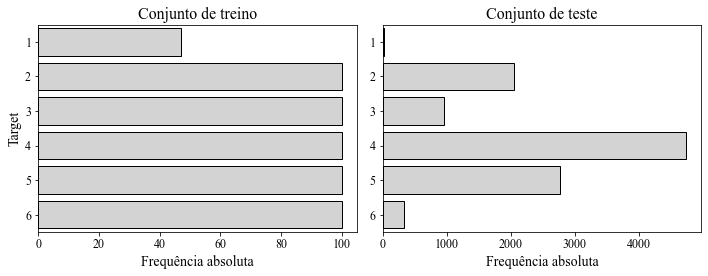

In [20]:
# layout dos plots
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# gráfico de barras dos dados de treino
sns.countplot(y = 'TARGET', data = train, color = col, edgecolor = ec, ax = axes[0])
axes[0].set_title("Conjunto de treino", size = fs_title)
axes[0].set_xlabel("Frequência absoluta", size = 14)
axes[0].set_ylabel("Target", size = 14)

# gráfico de barras dos dados de teste
sns.countplot(y = 'TARGET', data = test, color = col, edgecolor = ec, ax = axes[1])
axes[1].set_title("Conjunto de teste", size = fs_title)
axes[1].set_xlabel("Frequência absoluta", size = 14)
axes[1].set_ylabel("")

plt.tight_layout();

##### Visualização espacial dos dados de treino e teste

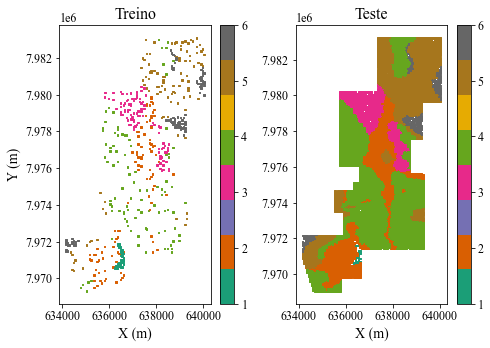

In [21]:
# layout dos plots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 5))

# Localização dos dados de treino
p1 = ax1.scatter(data = train, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
fig.colorbar(p1, ax = ax1)
ax1.set_title('Treino', size = fs_title)
ax1.set_xlabel('X (m)', size = 14)
ax1.set_ylabel('Y (m)', size = 14)

# Localização dos dados de teste
p2 = ax2.scatter(data = test, x = 'X', y = 'Y', c = 'TARGET', cmap = cm, s = sz, marker = mk)
fig.colorbar(p2, ax = ax2)
ax2.set_title('Teste', size = fs_title)
ax2.set_xlabel('X (m)', size = 14)

plt.tight_layout();

### Escalonamento das features

In [22]:
# instanciando o escalonador
std_scaler = StandardScaler()
    
# treinando o escalonador
std_scaler.fit(X_train)
    
# transformando features de treino
X_train_std = std_scaler.transform(X_train)
# transformando features de teste
X_test_std = std_scaler.transform(X_test)

In [23]:
# visualização das 5 primeiras linhas das features de treino normalizadas
pd.DataFrame(X_train_std, columns = df[FEAT].columns).head()

,GT,K,TH,U,CT,U_K,TH_K,U_TH,MDT,B01,...,B03,B04,B05,B06,B07,B08,B09,R,G,B
0,1.925042,0.294877,-0.315957,0.403014,0.080342,-0.570957,-0.613666,0.396018,-1.647478,-0.883643,...,-0.850956,-1.029210,-0.176277,-1.145369,-1.322683,-0.841989,-1.003773,-0.236750,1.247100,0.781578
1,-0.697592,-0.635175,1.709698,0.444511,0.357349,0.317860,1.654651,-1.175458,1.617799,-0.824130,...,-0.769237,-0.242417,-1.150729,-0.209394,-0.339503,-0.387236,0.658618,-0.965742,-0.301601,0.001767
2,0.564241,-0.305536,-0.422973,-0.316259,-0.462130,-0.272755,-0.446748,0.275135,-0.916880,-0.297013,...,-0.188918,-0.149952,-0.358138,0.092082,-0.017206,-0.427049,-0.528804,-0.008940,0.417998,0.086529
3,-0.669770,-0.258445,-0.945312,-0.583681,-0.519840,-0.382771,-0.247575,0.275135,1.040786,0.796330,...,0.963430,0.825973,0.468382,1.079967,1.151339,1.176975,3.587592,-0.282312,-0.817835,-0.540711
4,0.026334,-0.529220,-0.774596,-0.431527,-0.773763,-0.269859,-0.387077,-0.027072,-2.231456,-0.589478,...,-0.489737,-0.468536,-0.174241,-0.208596,-0.240436,-0.809254,-2.349518,-0.540497,-1.662581,-0.676330


### Análise de Componentes Principais

A **Análise de Componentes Principais (PCA)** será realizada apenas nos sensores Landsat 8, com o intuito de redução da dimensionalidade.

In [24]:
# instanciação do objeto PCA
pca = PCA(n_components = 9)

# treinamento e transformação das features de treino escalonadas
pcs = pca.fit_transform(X_train_std[:, np.arange(9,18)])

##### Variâncias relativas das componentes principais

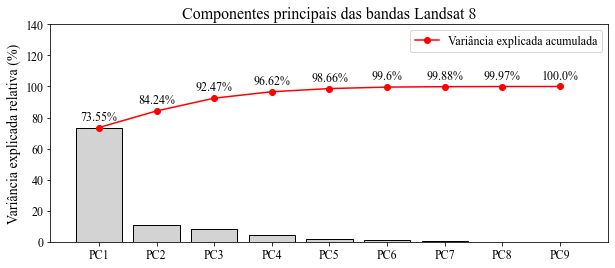

In [25]:
# variância explicada relativa de cada componente principal
explained_var = (pca.explained_variance_ratio_ * 100).round(2)
# variância explicada relativa acumulada
cum_explained_var = np.cumsum(explained_var).round(2)
# labels das componentes principais
labels = ['PC' + str(i) for i in range(1,10)]

# gráfico de barras de componentes principais
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(111)
plt.bar(x = labels, height = explained_var, color = 'lightgray', edgecolor = ec)
plt.title("Componentes principais das bandas Landsat 8", size = fs_title)
plt.ylabel("Variância explicada relativa (%)", size = 14)

# gráfico de linha de variâncias acumuladas
ax2 = fig.add_subplot(111)
plt.plot(labels, cum_explained_var, color = 'red', marker = 'o', label = 'Variância explicada acumulada')
plt.yticks(np.arange(0,160,20))
plt.legend(loc = 'top right')

# labels de variância explicada acumulada
for i, v in enumerate(cum_explained_var):
    ax2.text(i, v + 5, str(v) + '%', ha = 'center', size = 12);

- Como as três primeiras componentes principais explicam ~92% da variância presente nas nove bandas Landsat 8, podemos reduzir as iniciais 9 features para apenas 3 componentes.

##### PCA personalizada

Agora que a PCA foi realizada nas bandas Landsat 8 e obteve-se um resultado satisfatório no que diz respeito à variância explicada pelas três primeiras componentes principais, a PCA personalizada (classe `MaskedPCA`) pode ser realizada. Essa classe permite que a PCA seja realizada apenas nas features Landsat 8, retornando as três componentes principais, além das demais features não envolvidas na redução de dimensionalidade.

Como as nove bandas Landsat 8 foram redimensionadas para três componentes principais, após a PCA, o número de features total reduzirá de 21 para 15.

In [26]:
# criação de máscara com as features landsat 8
mask = np.arange(9,18)

# instanciação do objeto MaskedPCA
masked_pca = MaskedPCA(n_components = 3, mask = mask)

# treinamento e transformação das features de treino
X_train_pca = masked_pca.fit(X_train_std).transform(X_train_std)
print(f'Dimensões das features de treino (pré-PCA) = {X_train_std.shape}')
print(f'Dimensões das features de treino (pós-PCA) = {X_train_pca.shape}\n')

# treinamento e transformação das features de teste
X_test_pca = masked_pca.fit(X_test_std).transform(X_test_std)
print(f'Dimensões das features de teste (pré-PCA) = {X_test_std.shape}')
print(f'Dimensões das features de teste (pós-PCA) = {X_test_pca.shape}')

Dimensões das features de treino (pré-PCA) = (547, 21)
Dimensões das features de treino (pós-PCA) = (547, 15)

Dimensões das features de teste (pré-PCA) = (10871, 21)
Dimensões das features de teste (pós-PCA) = (10871, 15)


##### Correlação entre features de treino após a PCA

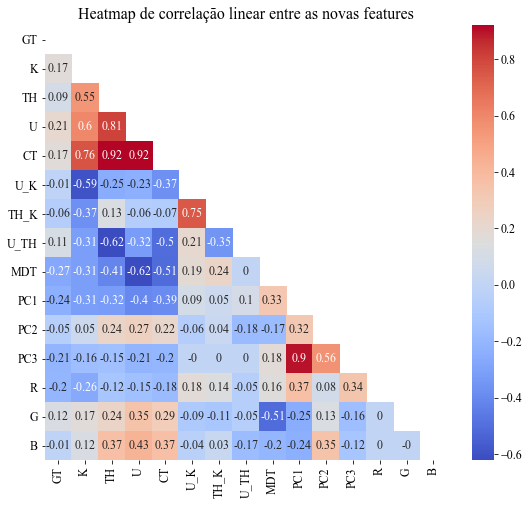

In [27]:
# lista de features após a redução da dimensionalidade
PCA_FEAT = ['GT','K','TH','U','CT','U_K','TH_K','U_TH','MDT','PC1','PC2','PC3','R','G','B']
# criação de um dataframe com as novas features
df_X_train_pca = pd.DataFrame(X_train_pca, columns = PCA_FEAT)

# Matriz de correlação linear entre as novas features
pca_corr = df_X_train_pca.corr(method = 'pearson').round(2)

# heatmap de correlação linear
plt.figure(figsize = (9, 8))
plt.title ('Heatmap de correlação linear entre as novas features', size = fs_title)
mask = np.triu(np.ones_like(pca_corr, dtype = np.bool))
ax = sns.heatmap(
                 pca_corr,
                 annot = True,
                 cmap = 'coolwarm',
                 cbar = True,
                 mask = mask
                );

### Seleção de features

#### Seleção univariada - Teste F ANOVA

In [28]:
# seleção das features (Teste f - ANOVA)
X_train_anova, X_test_anova, scores_anova = univariateSelector(X_train_pca, y_train, X_test_pca, f_classif, n_features = 10)

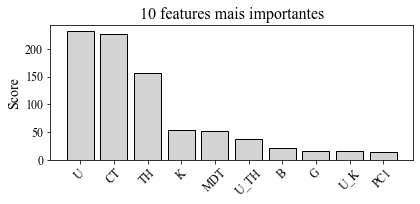

In [29]:
plotSelectionScores(scores_anova, PCA_FEAT, k = 10)

In [30]:
# as 10 features "mais importantes" de acordo com o teste F ANOVA
anova_dic = dicScores(scores_anova, k = 10, feature_labels = PCA_FEAT)
anova_dic

{'U': 231.94,
 'CT': 226.68,
 'TH': 155.98,
 'K': 53.82,
 'MDT': 51.09,
 'U_TH': 36.36,
 'B': 21.01,
 'G': 15.54,
 'U_K': 15.41,
 'PC1': 13.93}

#### Seleção univariada - Informação Mútua

In [31]:
# seleção das features (informação mútua)
X_train_mut, X_test_mut, scores_mut = univariateSelector(X_train_pca, y_train, X_test_pca, mutual_info_classif, n_features = 10)

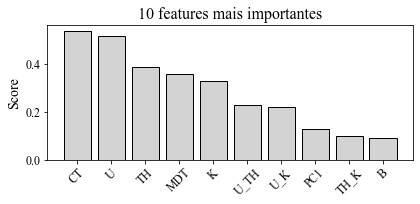

In [32]:
plotSelectionScores(scores_mut, PCA_FEAT, k = 10)

In [33]:
# as 10 features "mais importantes" de acordo com o teste F ANOVA
mutual_info_dic = dicScores(scores_mut, k = 10, feature_labels = PCA_FEAT)
mutual_info_dic

{'CT': 0.54,
 'U': 0.52,
 'TH': 0.39,
 'MDT': 0.36,
 'K': 0.33,
 'U_TH': 0.23,
 'U_K': 0.22,
 'PC1': 0.13,
 'TH_K': 0.1,
 'B': 0.09}

#### Seleção a partir do modelo - Random Forest

In [34]:
# instanciando random forest
model_rf = RandomForestClassifier(random_state = 42)

# seleção das features
X_train_rf, X_test_rf, rf_selector = modelSelector(X_train_pca, y_train, X_test_pca, model_rf, n_features = 10)

In [35]:
# índices booleanos das features
rf_index = rf_selector.get_support()
# features selecionadas
rf_features = list(df_X_train_pca.columns[rf_index])
print(f'Features selecionadas (Random Forest): {rf_features}')

Features selecionadas (Random Forest): ['GT', 'K', 'TH', 'U', 'CT', 'U_K', 'TH_K', 'U_TH', 'MDT', 'B']


#### Seleção a partir do modelo - Logistic Regression

In [36]:
# instanciando random forest
model_lr = LogisticRegression(multi_class = 'multinomial')

# seleção das features
X_train_lr, X_test_lr, lr_selector = modelSelector(X_train_pca, y_train, X_test_pca, model_lr, n_features = 10)

In [37]:
# índices booleanos das features
lr_index = lr_selector.get_support()
# features selecionadas
lr_features = list(df_X_train_pca.columns[lr_index])
print(f'Features selecionadas (Logistic Regression): {lr_features}')

Features selecionadas (Logistic Regression): ['K', 'TH', 'U', 'CT', 'U_K', 'TH_K', 'U_TH', 'MDT', 'PC1', 'PC3']


#### Resumo

In [38]:
# seleção univariada
print('Seleção univariada: \n')
# features selecionadas (Teste F ANOVA)
print(f'- Features selecionadas (Teste F ANOVA): {list(anova_dic.keys())}')
# features selecionadas (Informação Mútua)
print(f'- Features selecionadas (Info. Mútua): {list(mutual_info_dic.keys())} \n')
print('----')
# seleção a partir de um modelo
print('\nSeleção a partir de um modelo: \n')
# features selecionadas (Random Forest)
print(f'- Features selecionadas (Random Forest): {rf_features}')
# features selecionadas (Logistic Regression)
print(f'- Features selecionadas (Logistic Regression): {lr_features}')

Seleção univariada: 

- Features selecionadas (Teste F ANOVA): ['U', 'CT', 'TH', 'K', 'MDT', 'U_TH', 'B', 'G', 'U_K', 'PC1']
- Features selecionadas (Info. Mútua): ['CT', 'U', 'TH', 'MDT', 'K', 'U_TH', 'U_K', 'PC1', 'TH_K', 'B'] 

----

Seleção a partir de um modelo: 

- Features selecionadas (Random Forest): ['GT', 'K', 'TH', 'U', 'CT', 'U_K', 'TH_K', 'U_TH', 'MDT', 'B']
- Features selecionadas (Logistic Regression): ['K', 'TH', 'U', 'CT', 'U_K', 'TH_K', 'U_TH', 'MDT', 'PC1', 'PC3']


### Superamostragem

#### SMOTE

In [39]:
# oversampling dos dados de treino
X_train_smt, y_train_smt = SMOTE().fit_resample(X_train_anova, y_train)

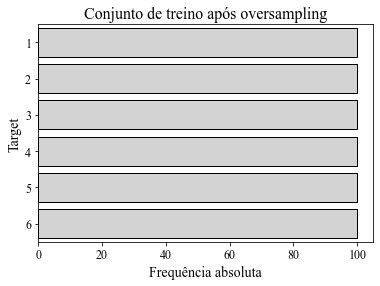

In [40]:
# transformação de narray em dataframe
train_smt = pd.DataFrame(X_train_smt, columns = anova_dic.keys())
train_smt['TARGET'] = y_train_smt

# gráfico de barras
sns.countplot(y = 'TARGET', data = train_smt, color = col, edgecolor = ec)

# título e labels do gráfico
plt.title("Conjunto de treino após oversampling", size = fs_title)
plt.xlabel("Frequência absoluta", size = 14)
plt.ylabel("Target", size = 14);

<a id='4'></a>
## Modelagem dos dados

### Divisão entre treino e teste

In [41]:
# dados de treino e teste
X_train, y_train, X_test, y_test = customTrainTestSplit(df, threshold = 100)

print(f"Treino: X {X_train.shape}, y {y_train.shape}")
print(f"Teste: X {X_test.shape}, y {y_test.shape}")

Treino: X (547, 21), y (547,)
Teste: X (10871, 21), y (10871,)


### Transformadores e outros objetos

In [42]:
# método de escalonamento de features
scaler = StandardScaler()

# PCA personalizada
mask = np.arange(9,18)
dim_reduction = MaskedPCA(n_components = 3, mask = mask)

# método de seleção de features
selector = SelectKBest(score_func = f_classif, k = 10)

# método de oversampling
oversamp = SMOTE(random_state = 42)

# número de folds da validação cruzada
n_folds = 5

# validação cruzada
cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

# métrica de performance
metric = 'f1_weighted'

### Criação de pipelines

Os pipelines abaixo são constituídos pelas seguintes etapas:

1. Escalonamento das features

2. Redução da dimensionalidade dos sensores Landsat 8

3. Seleção das features mais importantes

4. Superamostragem

5. Instanciação do classificador

In [43]:
# regressão logística multinomial (mlr)
mlr_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs'))])

# ridge classifier (rc)
rc_pipe = Pipeline(steps = [('scaler', scaler),
                            ('dim_reduction', dim_reduction),
                            ('selector', selector),
                            ('smote', oversamp),
                            ('clf', RidgeClassifier())])

# gaussian naive bayes (gnb)
gnb_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf',GaussianNB())])

# K-nearest neighbor (knn)
knn_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf',KNeighborsClassifier())])

# support vector classifier (svc)
svc_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', SVC(random_state = 42))])

# random forest (rf)
rf_pipe = Pipeline(steps = [('scaler', scaler),
                            ('dim_reduction', dim_reduction),
                            ('selector', selector),
                            ('smote', oversamp),
                            ('clf', RandomForestClassifier(random_state = 42))])

# xgboost classifier (xgb)
xgb_pipe = Pipeline(steps = [('scaler', scaler),
                             ('dim_reduction', dim_reduction),
                             ('selector', selector),
                             ('smote', oversamp),
                             ('clf', XGBClassifier(eval_metric = 'mlogloss', verbosity = 0, random_state = 42))])

In [44]:
# dicionário dos pipelines
pipe = {"MLR" : mlr_pipe,
        "RC"  : rc_pipe,
        "GNB" : gnb_pipe,
        "KNN" : knn_pipe,
        "SVC" : svc_pipe,
        "RF"  : rf_pipe,
        "XGB" : xgb_pipe}

### Treinamento dos classificadores

In [45]:
# treinamento dos classificadores
for p in pipe.keys():
    pipe[p].fit(X_train, y_train)

<a id='4'></a>
## Validação cruzada (pré-tuning)

In [46]:
validationReport(pipe, X_train, y_train, cv)

,MLR,RC,GNB,KNN,SVC,RF,XGB
f1_weighted,0.592,0.497,0.518,0.586,0.616,0.689,0.676
precision_weighted,0.598,0.517,0.596,0.609,0.622,0.690,0.676
recall_weighted,0.600,0.523,0.543,0.596,0.623,0.693,0.678
f1_macro,0.615,0.509,0.544,0.600,0.634,0.705,0.691
precision_macro,0.616,0.516,0.614,0.608,0.632,0.700,0.688
recall_macro,0.628,0.556,0.568,0.632,0.651,0.716,0.698
accuracy,0.600,0.523,0.543,0.596,0.623,0.693,0.678


<a id='5'></a>
## Tuning dos modelos

##### Dicionário dos parâmetros do grid

In [47]:
# parâmetros de tuning (multinomial logistic regression)
mlr_param = [{'clf__penalty' : ['l2'],
              'clf__solver'  : ['newton-cg','saga','sag','liblinear'],
              'clf__C'       : [0.001,0.01,0.1,1.0,10.0,100.0]}]

# parâmetros de tuning (ridge classifier)
rc_param = [{'clf__alpha'         : [0.01,0.1,1.0,10.0,100.0],
             'clf__solver'        : ['svd','sparse_cg','sag'],
             'clf__fit_intercept' : [True, False],
             'clf__normalize'     : [True, False]}]

# parâmetros de tuning (gaussian naive bayes)
gnb_param = [{'clf__var_smoothing' : [1,0.1,0.01,0.001,0.0001]}]

# parâmetros de tuning (k-nearest neighbor)
knn_param = [{'clf__n_neighbors'  : [3,7,11,15,19,21,23,25,27,30],
              'clf__weights'      : ['uniform', 'distance'],
              'clf__metric'       : ['minkowski', 'chebyshev'],
              'clf__p'            : [2,3]}]

# parâmetros de tuning (support vector machines)
svm_param = [{'clf__C'      : [0.001,0.01,0.1,1.0,10.0,100.0,1000.0],
              'clf__gamma'  : [0.001, 0.01, 0.1, 1, 10, 100, 'auto'],
              'clf__kernel' : ['poly', 'rbf']}]

# parâmetros de tuning (random forest)
rf_param = [{'clf__n_estimators'      : [25,50,100,500],
             'clf__max_depth'         : [15,25,30,None],
             'clf__criterion'         : ['gini', 'entropy'],
             'clf__min_samples_split' : [1,2,5,10],
             'clf__min_samples_leaf'  : [1,2,5,10]}]

# parâmetros de tuning (xgboost)
xgb_param = [{'clf__eta'               : [0.01,0.015,0.025,0.05,0.1],
              'clf__learning_rate'     : [0.1,0.15,0.2,0.25,0.3,0.35,0.4],
              'clf__gamma'             : [0.05,0.1,0.3,0.3,0.5,0.7,0.9,1.0],
              'clf__max_depth'         : [3,5,7,9,12,15,17,25],
              'clf__min_child_weight'  : [1,3,5,7],
              'clf__subsample'         : [0.6,0.7,0.8,0.9,1.0],
              'clf__colsample_bytree'  : [0.6,0.7,0.8,0.9,1.0],
              'clf__reg_lambda'        : [10 ** i for i in range(-3,4)],
              'clf__alpha'             : [10 ** i for i in range(-3,4)]}]

# listagem dos parâmetros de tuning
param = [mlr_param, rc_param, gnb_param, knn_param, svm_param, rf_param, xgb_param]

# dicionário dos parâmetros do grid
dic_param = {}
for k, p in zip(pipe.keys(), param):
    dic_param[k] = p

##### Tuning dos modelos

In [48]:
# para cada modelo, exceto random forest e xgboost
for m in ['MLR', 'RC', 'GNB', 'KNN', 'SVC']:
    # grid search
    grid = GridSearchCV(pipe[m], param_grid = dic_param[m], cv = cv, scoring = metric)
    grid.fit(X_train, y_train)
    print("----")
    print(m)
    print("Melhores parâmetros:", grid.best_params_)
    print('{0} = {1}'.format(metric, round(grid.best_score_, 3)))
    
# para apenas os modelos random forest e xgboost
for m in ['RF', 'XGB']:
    # random search
    random = RandomizedSearchCV(pipe[m], param_distributions = dic_param[m], cv = cv,
                                    scoring = metric, n_iter = 50, random_state = 42)
    random.fit(X_train, y_train)
    print("----")
    print(m)
    print("Melhores parâmetros:", random.best_params_)
    print('{0} = {1}'.format(metric, round(random.best_score_, 3)))

----
MLR
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}
f1_weighted = 0.592
----
RC
Melhores parâmetros: {'clf__alpha': 0.01, 'clf__fit_intercept': True, 'clf__normalize': False, 'clf__solver': 'svd'}
f1_weighted = 0.498
----
GNB
Melhores parâmetros: {'clf__var_smoothing': 0.001}
f1_weighted = 0.518
----
KNN
Melhores parâmetros: {'clf__metric': 'minkowski', 'clf__n_neighbors': 7, 'clf__p': 2, 'clf__weights': 'distance'}
f1_weighted = 0.614
----
SVC
Melhores parâmetros: {'clf__C': 100.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
f1_weighted = 0.652
----
RF
Melhores parâmetros: {'clf__n_estimators': 50, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 25, 'clf__criterion': 'entropy'}
f1_weighted = 0.692
----
XGB
Melhores parâmetros: {'clf__subsample': 0.9, 'clf__reg_lambda': 0.001, 'clf__min_child_weight': 1, 'clf__max_depth': 12, 'clf__learning_rate': 0.15, 'clf__gamma': 0.9, 'clf__eta': 0.05, 'clf__colsample_bytree': 0.9

<a id='6'></a>
## Validação cruzada (pós-tuning)

##### Criação dos pipelines dos modelos otimizados

In [49]:
# multinomial logistic regression (mlr)
mlr = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', LogisticRegression(C = 1.0, penalty = 'l2', multi_class = 'multinomial',
                                                   solver = 'newton-cg'))])

# ridge classifier (rc)
rc = Pipeline(steps = [('scaler', scaler),
                       ('dim_reduction', dim_reduction),
                       ('selector', selector),
                       ('smote', oversamp),
                       ('clf', RidgeClassifier(alpha = 0.01, fit_intercept = True, normalize = False,
                                               solver = 'svd'))])

# gaussian naive bayes (gnb)
gnb = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', GaussianNB(var_smoothing = 0.001))])

# k-nearest neighbor (knn)
knn = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', KNeighborsClassifier(metric = 'minkowski', n_neighbors = 7,
                                                     p = 2, weights = 'distance'))])

# support vector classifier (svc)
svc = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', SVC(C = 100.0, gamma = 0.01, kernel = 'rbf', random_state = 42))])

# random forest (rf)
rf = Pipeline(steps = [('scaler', scaler),
                       ('dim_reduction', dim_reduction),
                       ('selector', selector),
                       ('smote', oversamp),
                       ('clf', RandomForestClassifier(n_estimators = 50, min_samples_split = 2,
                                                      min_samples_leaf = 1, max_depth = 25,
                                                      criterion = 'entropy', random_state = 42))])

# xgboost classifier (xgb)
xgb = Pipeline(steps = [('scaler', scaler),
                        ('dim_reduction', dim_reduction),
                        ('selector', selector),
                        ('smote', oversamp),
                        ('clf', XGBClassifier(subsample = 0.9, reg_lambda = 0.001, min_child_weight = 1,
                                              max_depth = 12, learning_rate = 0.15, gamma = 0.9, 
                                              eta = 0.05, colsample_bytree = 0.9, alpha = 0.01,
                                              eval_metric = 'mlogloss', random_state = 42))])

# dicionário de modelos
models = {"MLR" : mlr,
          "RC"  : rc,
          "GNB" : gnb,
          "KNN" : knn,
          "SVC" : svc,
          "RF"  : rf,
          "XGB" : xgb}

##### Validação cruzada

In [50]:
# validação cruzada (pós-tuning)
val_report = validationReport(models, X_train, y_train, cv)
val_report

,MLR,RC,GNB,KNN,SVC,RF,XGB
f1_weighted,0.592,0.498,0.518,0.614,0.652,0.692,0.687
precision_weighted,0.598,0.519,0.596,0.633,0.660,0.694,0.688
recall_weighted,0.600,0.523,0.543,0.623,0.656,0.698,0.691
f1_macro,0.615,0.511,0.544,0.623,0.674,0.709,0.704
precision_macro,0.616,0.517,0.614,0.628,0.675,0.704,0.699
recall_macro,0.628,0.556,0.568,0.655,0.687,0.721,0.713
accuracy,0.600,0.523,0.543,0.623,0.656,0.698,0.691


<a id='7'></a>
## Predições das unidades

##### Treinamento dos modelos otimizados

In [51]:
# treinando os dois modelos selecionados
for k in models.keys():
    models[k].fit(X_train, y_train)

##### Predições

In [52]:
# predições multinomial logistic regression
ŷ_mlr = models['MLR'].predict(X_test)
# predições ridge classifier
ŷ_rc = models['RC'].predict(X_test)
# predições gaussian naive bayes
ŷ_gnb = models['GNB'].predict(X_test)
# predições k-nearest neighbor
ŷ_knn = models['KNN'].predict(X_test)
# predições k-nearest neighbor
ŷ_svc = models['SVC'].predict(X_test)
# predições random forest
ŷ_rf = models['RF'].predict(X_test)
# predições xgboost classifier
ŷ_xgb = models['XGB'].predict(X_test)

# dicionário de predições
dic_ŷ = {'MLR': ŷ_mlr, 'RC' : ŷ_rc, 'GNB' : ŷ_gnb, 'KNN' : ŷ_knn, 'SVC' : ŷ_svc, 'RF' : ŷ_rf, 'XGB' : ŷ_xgb}

##### Visualização das predições

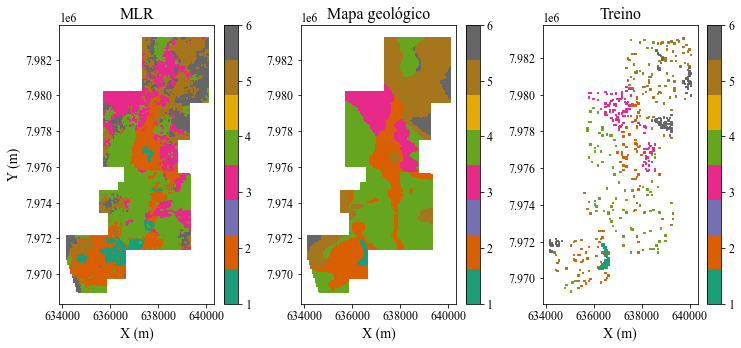

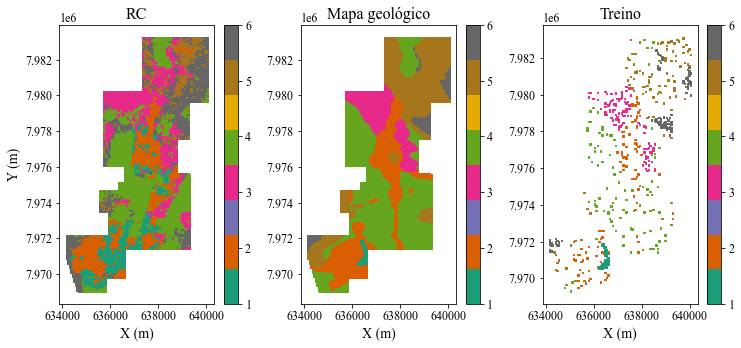

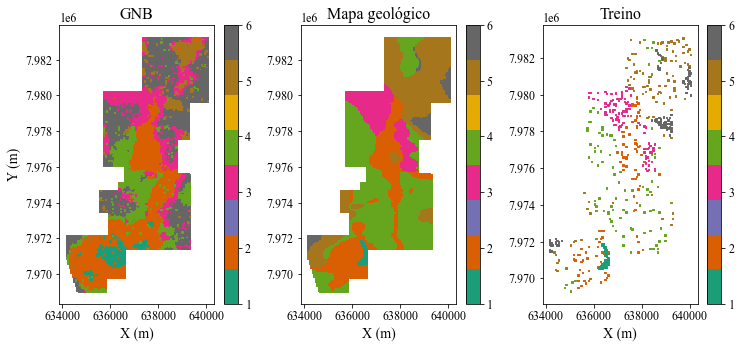

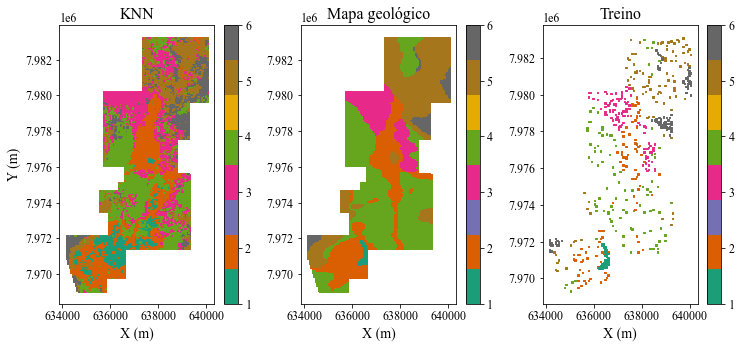

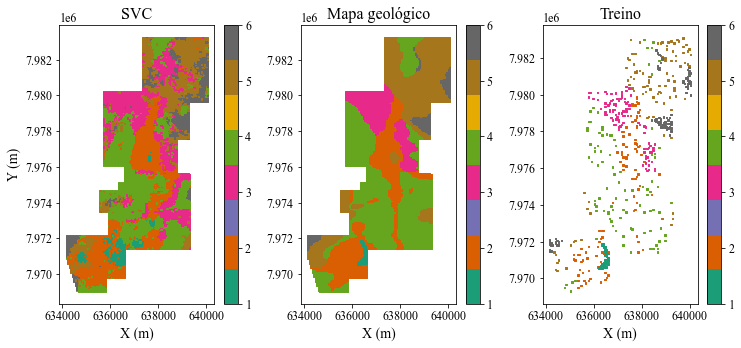

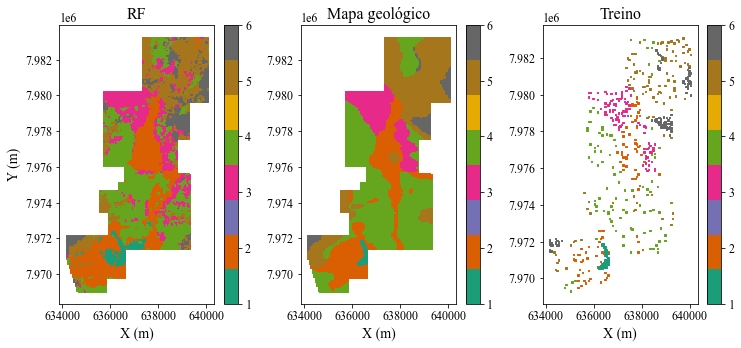

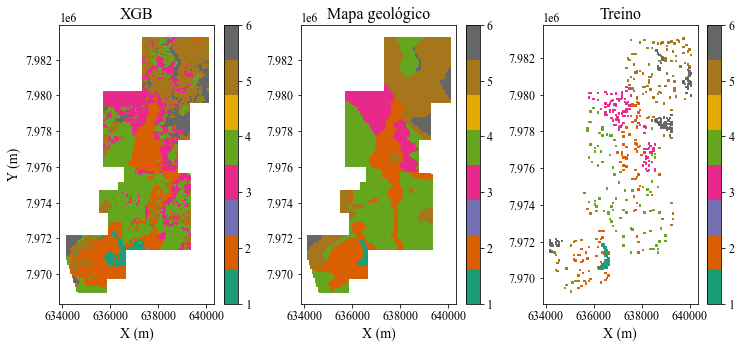

In [53]:
# plotagem das predições
for k in dic_ŷ.keys():
    plotPrediction(dic_ŷ[k], model = k);

<a id='7'></a>
## Validação dos modelos

##### Matriz de confusão

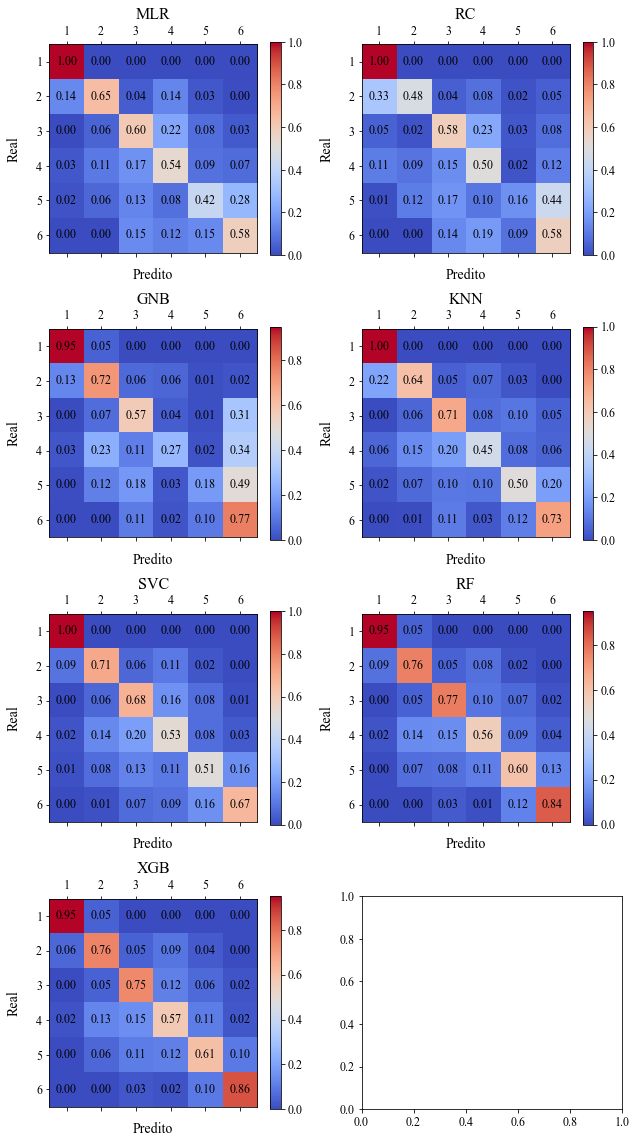

In [54]:
# layout dos plots
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize = (9, 16))

# labels
labels = [i for i in range(1, 7)]

for ax, k in zip(axs.flat, dic_ŷ.keys()):
    cm = confusion_matrix(y_test, dic_ŷ[k], normalize = 'true')
    p = ax.matshow(cm, cmap = 'coolwarm')
    fig.colorbar(p, ax = ax)
    ax.set_title(str(k), size = fs_title, pad = pad)
    ax.set_xlabel('Predito', size = 14, labelpad = pad)
    ax.set_xticklabels([''] + labels)
    ax.set_ylabel('Real', size = 14, labelpad = pad)
    ax.set_yticklabels([''] + labels)
    
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.2f}'.format(z), ha = 'center', va = 'center')
    
# layout ajustado
plt.tight_layout();

##### Report de métricas de classificação

In [55]:
for k in dic_ŷ.keys():
    print('---- \n')
    print(f'{k}: \n')
    print(classification_report(y_test, dic_ŷ[k]))

---- 

MLR: 

              precision    recall  f1-score   support

           1       0.04      1.00      0.08        20
           2       0.64      0.65      0.64      2044
           3       0.31      0.60      0.41       965
           4       0.77      0.54      0.63      4739
           5       0.66      0.42      0.52      2774
           6       0.14      0.58      0.23       329

    accuracy                           0.54     10871
   macro avg       0.43      0.63      0.42     10871
weighted avg       0.66      0.54      0.57     10871

---- 

RC: 

              precision    recall  f1-score   support

           1       0.02      1.00      0.03        20
           2       0.56      0.48      0.52      2044
           3       0.30      0.58      0.39       965
           4       0.77      0.50      0.61      4739
           5       0.70      0.16      0.27      2774
           6       0.09      0.58      0.15       329

    accuracy                           0.42     10

##### Métricas de validação do conjunto de teste

In [56]:
test_report = testReport(dic_ŷ, y_test)
test_report

,MLR,RC,GNB,KNN,SVC,RF,XGB
f1_weighted,0.572,0.469,0.400,0.569,0.599,0.652,0.655
precision_weighted,0.657,0.647,0.687,0.681,0.673,0.713,0.706
recall_weighted,0.537,0.422,0.372,0.534,0.576,0.636,0.642
f1_macro,0.418,0.327,0.316,0.436,0.466,0.526,0.541
precision_macro,0.428,0.405,0.423,0.446,0.456,0.500,0.509
recall_macro,0.632,0.551,0.575,0.673,0.683,0.747,0.750
accuracy,0.537,0.422,0.372,0.534,0.576,0.636,0.642


##### Comparação entre os resultados de validação e teste

In [57]:
print("Validação:")
print(val_report)
print('\n----\n')
print("Teste:")
print(test_report)

Validação:
                      MLR     RC    GNB    KNN    SVC     RF    XGB
f1_weighted         0.592  0.498  0.518  0.614  0.652  0.692  0.687
precision_weighted  0.598  0.519  0.596  0.633  0.660  0.694  0.688
recall_weighted     0.600  0.523  0.543  0.623  0.656  0.698  0.691
f1_macro            0.615  0.511  0.544  0.623  0.674  0.709  0.704
precision_macro     0.616  0.517  0.614  0.628  0.675  0.704  0.699
recall_macro        0.628  0.556  0.568  0.655  0.687  0.721  0.713
accuracy            0.600  0.523  0.543  0.623  0.656  0.698  0.691

----

Teste:
                      MLR     RC    GNB    KNN    SVC     RF    XGB
f1_weighted         0.572  0.469  0.400  0.569  0.599  0.652  0.655
precision_weighted  0.657  0.647  0.687  0.681  0.673  0.713  0.706
recall_weighted     0.537  0.422  0.372  0.534  0.576  0.636  0.642
f1_macro            0.418  0.327  0.316  0.436  0.466  0.526  0.541
precision_macro     0.428  0.405  0.423  0.446  0.456  0.500  0.509
recall_macro        0.6

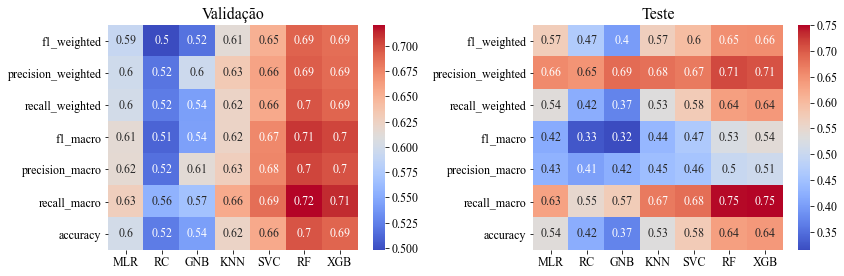

In [58]:
# layout dos heatmaps
fig, ax = plt.subplots(1,2,figsize = (12, 4))

# heatmap para o conjunto de validação
sns.heatmap(val_report, cmap = 'coolwarm', annot = True, ax = ax[0])
ax[0].set_title('Validação', size = fs_title)

# heatmap para o conjunto de teste
sns.heatmap(test_report, cmap = 'coolwarm', annot = True, ax = ax[1])
ax[1].set_title('Teste', size = fs_title)

plt.tight_layout();

<a id='8'></a>
## Importância das features

### Entropia

In [59]:
# dicionário de features e seus respectivos scores de importância
dic_importance = featureImportance(models)

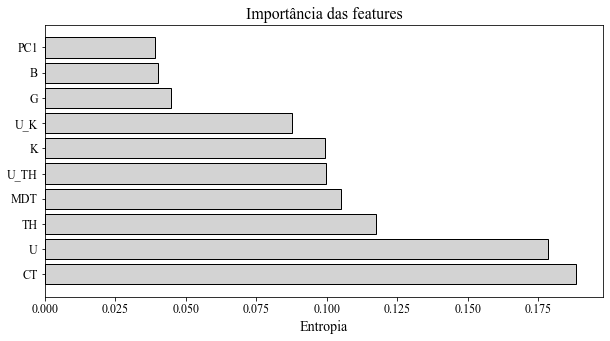

In [61]:
# gráfico de importância de features
plt.figure(figsize = (10,5))
plt.barh(list(dic_importance.keys()), dic_importance.values(), color =col, edgecolor = ec)
plt.title('Importância das features', size = fs_title)
plt.xlabel('Entropia', size = 14);